In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory('C:/Users/HI/Desktop/mk/adultclassifier/nudedata/train',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 6342 files belonging to 2 classes.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory('C:/Users/HI/Desktop/mk/adultclassifier/nudedata/val',
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1586 files belonging to 2 classes.


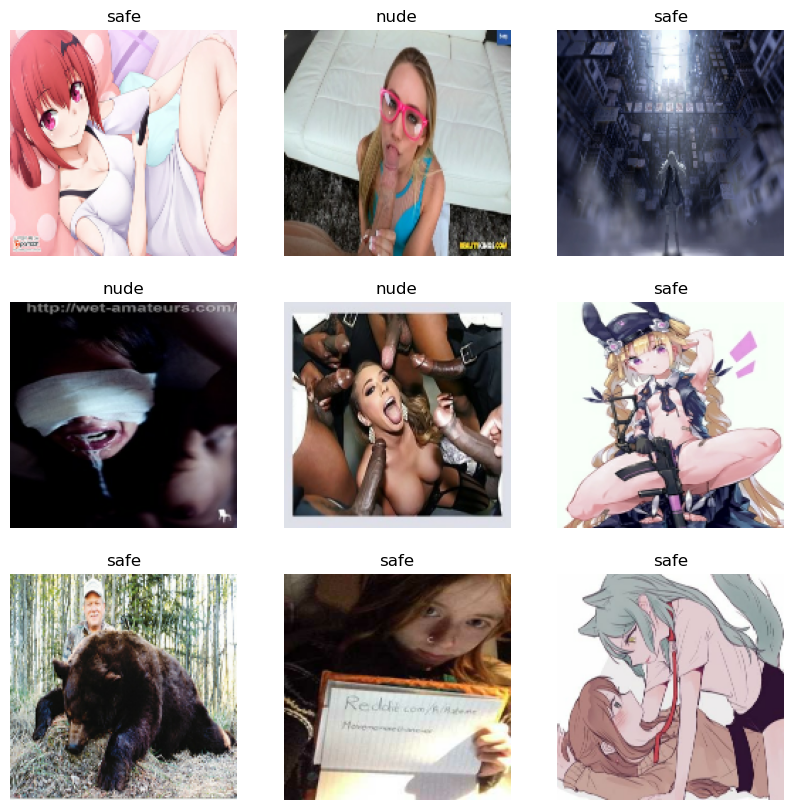

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),])

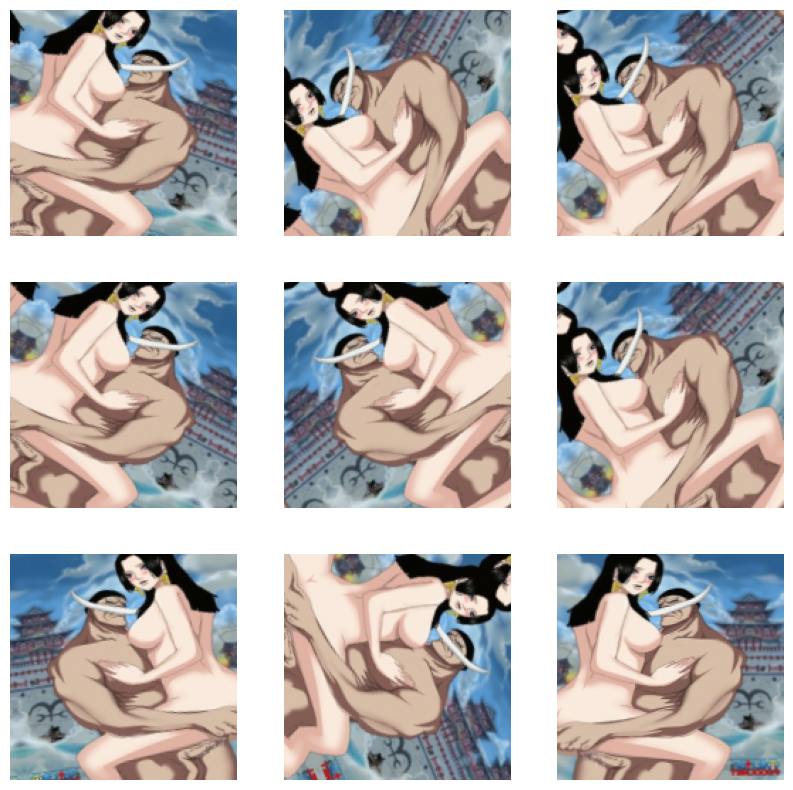

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [14]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.
#see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [16]:
# Freeze the convolutional base

In [17]:
base_model.trainable = False

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [20]:
#To generate predictions from the block of features, average over the spatial 5x5 spatial locations, 
# using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
# Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. 
# You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. 
# Positive numbers predict class 1, negative numbers predict class 0.

In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [24]:
# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.
# As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [25]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
# Compile the model before training it. Since there are two classes,
# use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
# The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand trainable parameters in the Dense layer. 
# These are divided between two tf.Variable objects, the weights and biases.

In [29]:
len(model.trainable_variables)

2

In [31]:
# Train the model

In [32]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

50/50 [==============================] - 62s 834ms/step - loss: 0.8827 - accuracy: 0.5290


In [33]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.88
initial accuracy: 0.53


In [34]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
199/199 [==============================] - 253s 1s/step - loss: 0.7114 - accuracy: 0.6038 - val_loss: 0.5569 - val_accuracy: 0.6665
Epoch 2/10
199/199 [==============================] - 214s 1s/step - loss: 0.5179 - accuracy: 0.7250 - val_loss: 0.4549 - val_accuracy: 0.7509
Epoch 3/10
199/199 [==============================] - 219s 1s/step - loss: 0.4432 - accuracy: 0.7756 - val_loss: 0.4118 - val_accuracy: 0.7888
Epoch 4/10
199/199 [==============================] - 216s 1s/step - loss: 0.3960 - accuracy: 0.8103 - val_loss: 0.3856 - val_accuracy: 0.8127
Epoch 5/10
199/199 [==============================] - 216s 1s/step - loss: 0.3725 - accuracy: 0.8232 - val_loss: 0.3676 - val_accuracy: 0.8329
Epoch 6/10
199/199 [==============================] - 218s 1s/step - loss: 0.3663 - accuracy: 0.8308 - val_loss: 0.3544 - val_accuracy: 0.8411
Epoch 7/10
199/199 [==============================] - 215s 1s/step - loss: 0.3509 - accuracy: 0.8338 - val_loss: 0.3443 - val_accuracy: 0.8449

In [35]:
# Learning curves

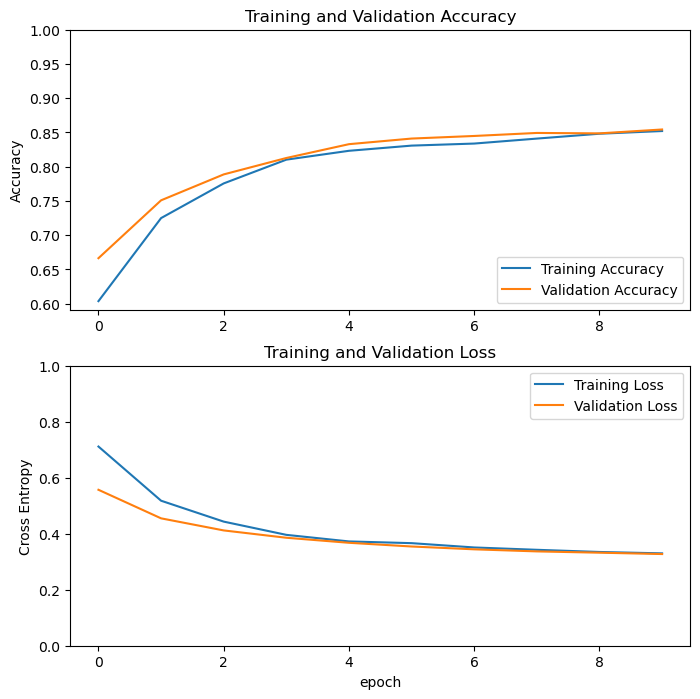

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
# Fine tuning

In [38]:
# In the feature extraction experiment, we only training a few layers on top of an MobileNetV2 base model.
# The weights of the pre-trained network were not updated during training.

# One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model 
# alongside the training of the classifier you added. The training process 
# will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [39]:
# Un-freeze the top layers of the model

In [40]:
base_model.trainable = True

In [41]:
# see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [42]:
# Compile the model

In [43]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [45]:
len(model.trainable_variables)

56

In [46]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
199/199 [==============================] - 279s 1s/step - loss: 0.3127 - accuracy: 0.8557 - val_loss: 0.2928 - val_accuracy: 0.8878
Epoch 11/20
199/199 [==============================] - 249s 1s/step - loss: 0.2728 - accuracy: 0.8798 - val_loss: 0.3027 - val_accuracy: 0.8638
Epoch 12/20
199/199 [==============================] - 256s 1s/step - loss: 0.2631 - accuracy: 0.8923 - val_loss: 0.2597 - val_accuracy: 0.9029
Epoch 13/20
199/199 [==============================] - 245s 1s/step - loss: 0.2396 - accuracy: 0.8951 - val_loss: 0.2536 - val_accuracy: 0.9023
Epoch 14/20
199/199 [==============================] - 248s 1s/step - loss: 0.2341 - accuracy: 0.8989 - val_loss: 0.2464 - val_accuracy: 0.9061
Epoch 15/20
199/199 [==============================] - 255s 1s/step - loss: 0.2251 - accuracy: 0.9029 - val_loss: 0.2477 - val_accuracy: 0.9029
Epoch 16/20
199/199 [==============================] - 247s 1s/step - loss: 0.2134 - accuracy: 0.9095 - val_loss: 0.2517 - val_accuracy:

In [47]:
# learning curves of the training and validation accuracy/loss when fine-tuning the last few layers
# of the MobileNetV2 base model and training the classifier on top of it.

In [48]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

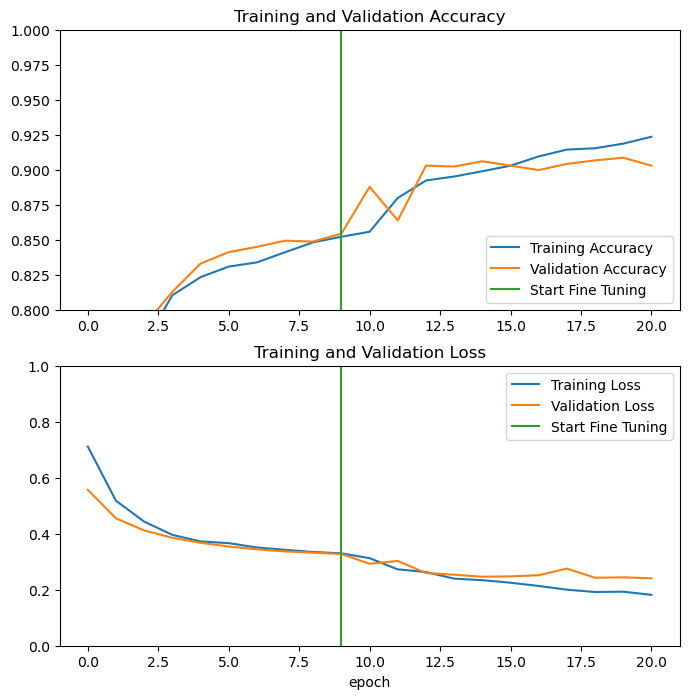

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
# Evaluation and prediction

In [68]:
loss, accuracy = history_fine.model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

50/50 [==============================] - 35s 702ms/step - loss: 0.2407 - accuracy: 0.9029
Test accuracy : 0.9029003977775574


Predictions:
 [0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1]
Labels:
 [0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1]


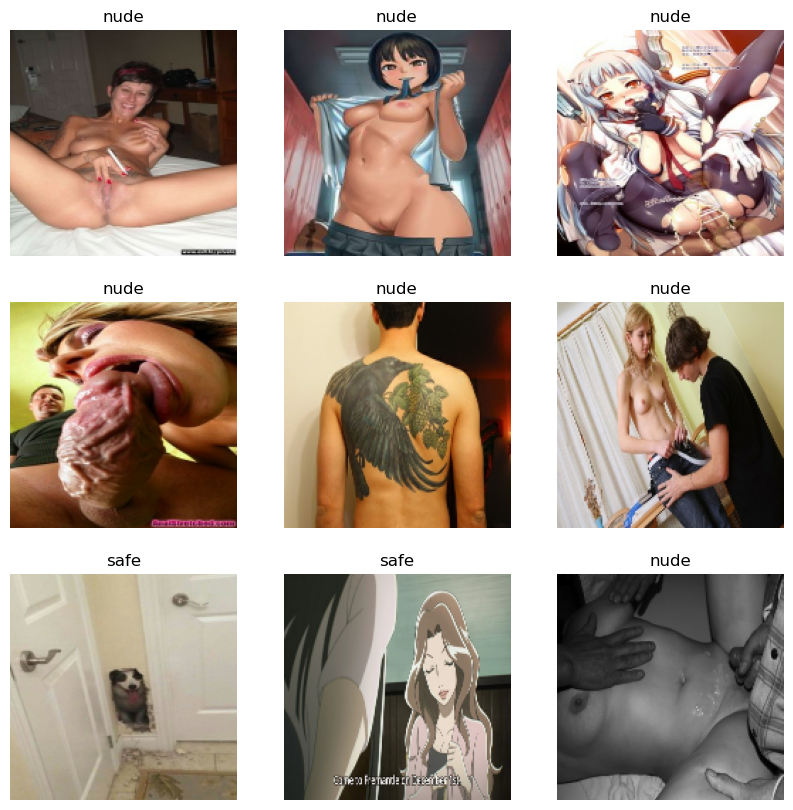

In [103]:
# Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [104]:
import numpy as np  
import keras.utils as image

test_image = image.load_img('C:/Users/HI/Desktop/mk/adultclassifier/adult/adult.jpg', target_size = (160, 160))  
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image, axis = 0)  
result = model.predict(test_image)  

if result[0][0] == 1:  
  prediction = 'safe'  
else:  
  prediction = 'nude'  
  
print(prediction)
print(result[0][0])

1/1 [==============================] - 0s 85ms/step
nude
-4.6537256


In [102]:
result= model.predict(test_image)
print(result[0][0])

1/1 [==============================] - 0s 101ms/step
-4.6537256


In [84]:
test_image = image.load_img('C:/Users/HI/Desktop/mk/adultclassifier/adult/adult2.jpg', target_size = (160, 160))  
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image, axis = 0)  
result = history_fine.model.predict(test_image)  

if result[0][0] == 1:  
  prediction = 'safe'  
else:  
  prediction = 'nude'  
  
print(prediction)
print(result[0][0])

1/1 [==============================] - 0s 116ms/step
nude
-3.4054377


In [85]:
test_image = image.load_img('C:/Users/HI/Desktop/mk/adultclassifier/adult/adult3.jpg', target_size = (160, 160))  
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image, axis = 0)  
result = history_fine.model.predict(test_image)  

if result[0][0] == 1:  
  prediction = 'safe'  
else:  
  prediction = 'nude'  
  
print(prediction)
print(result[0][0])

1/1 [==============================] - 0s 123ms/step
nude
-5.3103614


In [86]:
test_image = image.load_img('C:/Users/HI/Desktop/mk/adultclassifier/adult/adult4.jpg', target_size = (160, 160))  
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image, axis = 0)  
result = history_fine.model.predict(test_image)  

if result[0][0] == 1:  
  prediction = 'safe'  
else:  
  prediction = 'nude'  
  
print(prediction)
print(result[0][0])

1/1 [==============================] - 0s 98ms/step
nude
-3.7040803


In [87]:
test_image = image.load_img('C:/Users/HI/Desktop/mk/adultclassifier/adult/adult5.jpg', target_size = (160, 160))  
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image, axis = 0)  
result = history_fine.model.predict(test_image)  

if result[0][0] == 1:  
  prediction = 'safe'  
else:  
  prediction = 'nude'  
  
print(prediction)
print(result[0][0])

1/1 [==============================] - 0s 218ms/step
nude
-3.8313355


In [88]:
test_image = image.load_img('C:/Users/HI/Desktop/mk/adultclassifier/adult/adult6.jpg', target_size = (160, 160))  
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image, axis = 0)  
result = history_fine.model.predict(test_image)  

if result[0][0] == 1:  
  prediction = 'safe'  
else:  
  prediction = 'nude'  
  
print(prediction)
print(result[0][0])

1/1 [==============================] - 0s 145ms/step
nude
-2.6169093


In [105]:
test_image = image.load_img('C:/Users/HI/Desktop/mk/adultclassifier/adult/na.jpg', target_size = (160, 160))  
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image, axis = 0)  
result = model.predict(test_image)  

if result[0][0] == 1:  
  prediction = 'safe'  
else:  
  prediction = 'nude'  
  
print(prediction)
print(result[0][0])

1/1 [==============================] - 0s 85ms/step
nude
1.7111286


In [106]:
test_image = image.load_img('C:/Users/HI/Desktop/mk/adultclassifier/adult/na1.jpg', target_size = (160, 160))  
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image, axis = 0)  
result = model.predict(test_image)  

if result[0][0] == 1:  
  prediction = 'safe'  
else:  
  prediction = 'nude'  
  
print(prediction)
print(result[0][0])

1/1 [==============================] - 0s 287ms/step
nude
6.3548


In [98]:
test_image = image.load_img('C:/Users/HI/Desktop/mk/adultclassifier/adult/safe.jpg', target_size = (160, 160))  
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image, axis = 0)  
result = history_fine.model.predict(test_image)  

if result[0][0] == 1:  
  prediction = 'safe'  
else:  
  prediction = 'nude'  
  
print(prediction)
print(result[0][0])

1/1 [==============================] - 0s 131ms/step
nude
1.0317656


In [92]:
test_image = image.load_img('C:/Users/HI/Desktop/mk/adultclassifier/adult/safe6.jpg', target_size = (160, 160))  
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image, axis = 0)  
result = history_fine.model.predict(test_image)  

if result[0][0] == 1:  
  prediction = 'safe'  
else:  
  prediction = 'nude'  
  
print(prediction)
print(result[0][0])

1/1 [==============================] - 0s 76ms/step
nude
3.559348
